<p>This notebook is a demonstration of two types of feature engineering methods:<br><br>
<ul>
    <li>Creating non-linear transformations of individual features</li>
    <li>Transforming continuous or discrete features in binary bins - aka "binning"</li>
</ul><br><br>

The first thing we do is write a few functions that make transformations.
</p>

In [1]:
'''
Binning vs transformation
'''

from sklearn import linear_model
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def genY(x, err, betas):
    '''
    Goal: generate a Y variable as Y=XB+e 
    Input
    1. an np array x of length n
    2. a random noise vector r of length n
    3. a (d+1) x 1 vector of coefficients b - each represents ith degree of x
    '''
    d = pd.DataFrame(x, columns=['x'])    
    y = err
    for i,b in enumerate(betas):
        y = y + b*x**i
    d['y'] = y
    return d


def makePolyFeat(d, deg):
    '''
    Goal: Generate features up to X**deg
    1. a data frame with two features X and Y
    4. a degree 'deg' (from which we make polynomial features 
    
    '''
    #Generate Polynomial terms
    for i in range(2, deg+1):
        d['x'+str(i)] = d['x']**i
    return d



def makeBin(d, bins):
    '''
    This takes in a dataframe with a feature X and makes evenly spaced bin features
    using the pandas get_dummies function
    '''
    d['g'] = np.floor(bins*(d['x']-d['x'].min())/(d['x'].max()-d['x'].min())).astype(int)
    d['g']=-1*(d['g']==bins)+d['g'] #Puts the highest entry into the right bin
    #Note that the get_dummies function makes k dummy features if there are k
    #discrete values. In modeling you should always use k-1 bins
    dummies = pd.get_dummies(d['g'], prefix='bin')
    d_m = pd.merge(d, dummies, left_index=True, right_index=True, how='inner')
    del d_m['g'] #we don't need this
    del d_m['bin_0'] #we don't need this either
    return d_m
    



<p>Now that we've created the functions, let's generate some data. Again, the goal is to generate an X-Y relationship with noise, but where we know the underlying data generating distribution.
</p>

In [2]:
betas = [0, 4, -3.5, 1]
n=200
sig=2.2
sp=20

x_init = np.random.uniform(0,1,n)
e_init = np.random.normal(0, sig, n)

dat = genY(x_init, e_init, betas)
dat = makePolyFeat(dat, 6)


<p>Now we want to see the effect of fitting polynomial curves of different degrees to our noisy data set. Ultimately, we want to illustrate how model specification (and feature engineering) affects the bias-variance tradeoff.


</p>

In [3]:
def PlotLinDeg(X_train, y_train, X_test, y_test, i, t):
    '''
    This function builds a regression model on the simulated data
    1. plots the test data
    2. plots the fitted line
    3. Shows sum-square error
    '''
    regr = linear_model.LinearRegression(fit_intercept=True)
    regr.fit(X_train, y_train)
    y_hat=regr.predict(X_train)
    y_hat_test=regr.predict(X_test)
    ss_train=((y_train-y_hat)**2).mean()
    ss_test=((y_test-y_hat_test)**2).mean()
    #Plot train X vs. Predicted Y_train
    plt.subplot(2, 3, i)
    plt.plot(X_train['x'], y_train, 'b.')
    plt.plot(X_train['x'], y_hat, 'r.')
    plt.title('{}\n Train MSE={}'.format(t,round(ss_train,4)))
    #Plot test X vs. Predicted Y_test
    plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
    plt.subplot(2,3,i+3)
    plt.plot(X_test['x'], y_test, 'b.')
    plt.plot(X_test['x'], y_hat_test, 'r.')
    plt.title('Test MSE={}'.format(round(ss_test,4)))
    plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
    
    
def PlotLinBin(X_train, y_train, X_test, y_test, i, t, x, x_t):
    '''
    This function builds a regression model on the simulated data
    1. plots the test data
    2. plots the fitted line
    3. Shows sum-square error
    '''
    regr = linear_model.LinearRegression(fit_intercept=True)
    regr.fit(X_train, y_train)
    y_hat=regr.predict(X_train)
    y_hat_test=regr.predict(X_test)
    ss_train=((y_train-y_hat)**2).mean()
    ss_test=((y_test-y_hat_test)**2).mean()
    #Plot train X vs. Predicted Y_train
    plt.subplot(2, 3, i)
    plt.plot(x, y_train, 'b.')
    plt.plot(x, y_hat, 'r.')
    plt.title('{}\n Train MSE={}'.format(t,round(ss_train,4)))
    #Plot test X vs. Predicted Y_test
    plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
    plt.subplot(2,3,i+3)
    plt.plot(x_t, y_test, 'b.')
    plt.plot(x_t, y_hat_test, 'r.')
    plt.title('Test MSE={}'.format(round(ss_test,4)))
    plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')



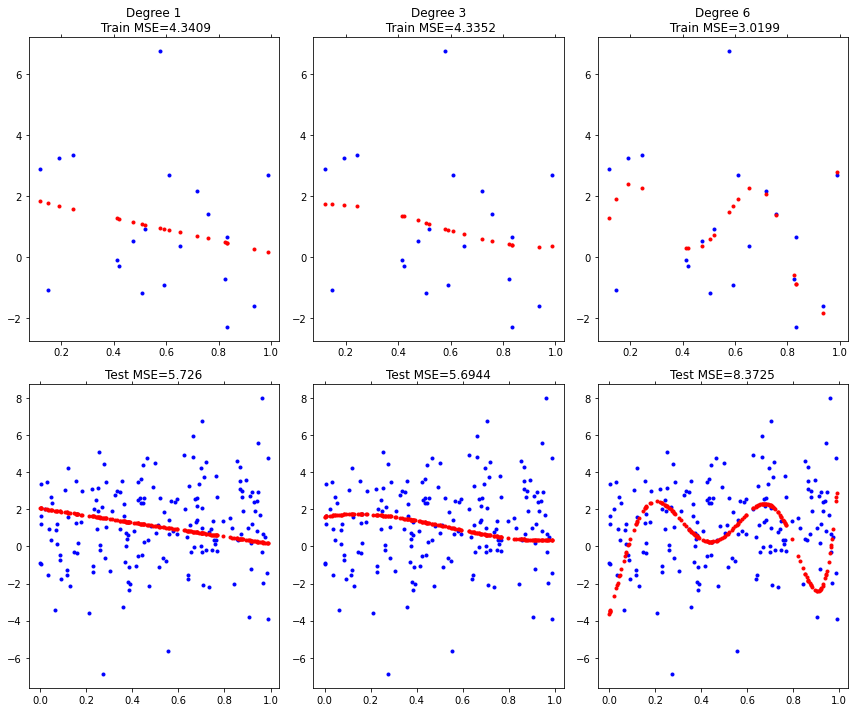

In [4]:
sp = 20

f1=['x']; f3=['x', 'x2', 'x3']; f6=['x', 'x2', 'x3', 'x4', 'x5', 'x6']

fig=plt.figure(figsize=(12,10))

j=1
for plot in [f1,f3,f6]:
    PlotLinDeg(dat[plot][:sp], dat['y'][:sp], dat[plot][sp:], dat['y'][sp:], j, 'Degree '+str(len(plot)))
    j+=1

fig.tight_layout()

plt.show()

<p>The above plot is a great illustration of bias-variance tradeoffs. The top row shows an nth-degree model fit to a sparse training set. The bottom row shows this fitted model against the test data (with actuals in blue and predicted in red). We can see multiple things here:<br>
<ul>
    <li>MSE gets much better on training data as we increase the degree to 6</li>
    <li>MSE gets notably worse on test data as we increase the degree from 3 to 6</li>
    <li>A linear model is notably biased (has the worst training error), but the error from bias is better than the error induced from overfitting (i.e., the high variance model)</li>
</ul><br>

Now let's do a similar experiment with the bin features.
</p>

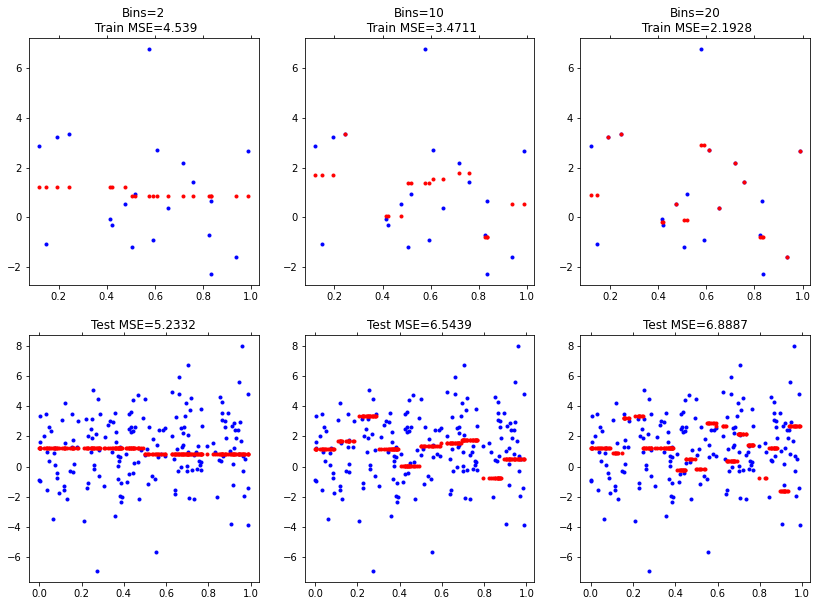

In [5]:
def getBinName(vl, pre):
    l=[]
    for v in vl:
        if (pre in v):
            l.append(v)
    return l

plt.figure(figsize=(14,10))

j=1
for binvals in [2,10,20]:  ## Arbitrary bin values can be chosen here

    d = makeBin(dat,binvals); g = getBinName(d.columns.values,'bin')
    PlotLinBin(d[g][:sp], d['y'][:sp], d[g][sp:], d['y'][sp:], j, 'Bins='+str(binvals), d['x'][:sp], d['x'][sp:])
    j+=1

plt.tight_layout()

plt.show()